In [1]:
import os
import itertools
from keras.callbacks import EarlyStopping
from keras import backend as K
from sklearn.metrics import f1_score
import tools_stable as tools
import plot_confusion_matrix_Copy1 as plot_confusion_matrix
from sklearn.metrics import confusion_matrix

training_data, training_label, validation_data, validation_label, validation_cate_label = tools.get_data()

ks = 5
num_layer = 10
bs = 30
lr = 0.0001

Using TensorFlow backend.


Train Data: (10151, 9000, 1)
Train Label:  (10151, 4)
KFold(n_splits=5, random_state=None, shuffle=True)
trian: [    0     1     2 ... 10147 10148 10149] len 8120 test: [    4     6    11 ... 10135 10138 10150] len 2031
trian: [    0     3     4 ... 10148 10149 10150] len 8121 test: [    1     2     8 ... 10124 10136 10137] len 2030
trian: [    1     2     3 ... 10148 10149 10150] len 8121 test: [    0     5    20 ... 10144 10146 10147] len 2030
trian: [    0     1     2 ... 10146 10147 10150] len 8121 test: [    3     7    14 ... 10143 10148 10149] len 2030
trian: [    0     1     2 ... 10148 10149 10150] len 8121 test: [   10    12    15 ... 10141 10142 10145] len 2030


In [2]:
import numpy as np
cnf_matrix = np.array([[142, 3, 3, 21],[8, 1127, 15, 65], [6, 7, 35, 5], [27, 119, 14, 434]])
plot_confusion_matrix.plot_confusion_matrix(cnf_matrix, classes=['AF','Normal','Noisy','Other'], save_png=True)

In [15]:
def run(bs, lr, ks, num_layer):
    fold=1
    for index, (X_train, Y_train, X_val, Y_val, val_cat) in enumerate(zip(training_data,
                                                       training_label,
                                                       validation_data,
                                                       validation_label,
                                                       validation_cate_label)):
        if index != 0: continue
        model = tools.create_model(lr, bs, ks, num_layer)
        print("Fold "+str(fold))
        early_stop = EarlyStopping(patience=20)
        history = model.fit(x = X_train, 
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_val, Y_val),
                            callbacks=[early_stop],
                            batch_size=bs, 
                            verbose=1)
        evaluation = model.evaluate(x = X_val, y = Y_val)
        validation_prediction = model.predict_classes(X_val, batch_size=bs)
        score = f1_score(val_cat, validation_prediction, average=None)
        print(score)
        
#         tools.show_plot(inner_path, history)
        fold = fold + 1
        
        test_prediction = model.predict_classes(X_val, batch_size=1)
        cnf_matrix = confusion_matrix(val_cat, test_prediction)
        plot_confusion_matrix.plot_confusion_matrix(cnf_matrix, classes=['AF','Noise','Normal','Other'], save_png=True)
        
        return X_val, val_cat, validation_prediction
    
f1_X_val, f1_val_cat, f1_validation_prediction = run(bs, lr, ks, num_layer)

Fold 1
Train on 8120 samples, validate on 2031 samples
Epoch 1/100
8120/8120 [==============================] - 12s 1ms/step - loss: 1.0242 - acc: 0.5709 - val_loss: 0.9721 - val_acc: 0.5982
Epoch 2/100
8120/8120 [==============================] - 9s 1ms/step - loss: 0.9252 - acc: 0.5921 - val_loss: 0.9830 - val_acc: 0.6470
Epoch 3/100
8120/8120 [==============================] - 9s 1ms/step - loss: 0.8852 - acc: 0.6212 - val_loss: 0.7966 - val_acc: 0.6598
Epoch 4/100
8120/8120 [==============================] - 9s 1ms/step - loss: 0.8243 - acc: 0.6536 - val_loss: 0.7976 - val_acc: 0.6568
Epoch 5/100
8120/8120 [==============================] - 9s 1ms/step - loss: 0.7759 - acc: 0.6648 - val_loss: 0.7608 - val_acc: 0.6627
Epoch 6/100
8120/8120 [==============================] - 9s 1ms/step - loss: 0.7309 - acc: 0.6972 - val_loss: 0.6875 - val_acc: 0.7016
Epoch 7/100
8120/8120 [==============================] - 9s 1ms/step - loss: 0.6807 - acc: 0.7124 - val_loss: 0.6655 - val_acc: 0.7336

In [78]:
from sklearn.utils import class_weight
import numpy as np
def run(bs, lr, ks, num_layer):
    fold=1
    for index, (X_train, Y_train, X_val, Y_val, val_cat) in enumerate(zip(training_data,
                                                       training_label,
                                                       validation_data,
                                                       validation_label,
                                                       validation_cate_label)):
        if index != 0: continue
        train_cat = [np.where(r==1) for r in Y_train]
        cat = [r[0].tolist()[0] for r in train_cat]
        class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(cat),
                                                 cat)
        model = tools.create_model(lr, bs, ks, num_layer)
        print("Fold "+str(fold))
        early_stop = EarlyStopping(patience=20)
        history = model.fit(x = X_train, 
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_val, Y_val),
                            callbacks=[early_stop],
                            batch_size=bs,
                            class_weight=class_weights,
                            verbose=1)
        evaluation = model.evaluate(x = X_val, y = Y_val)
        validation_prediction = model.predict_classes(X_val, batch_size=bs)
        score = f1_score(val_cat, validation_prediction, average=None)
        print(score)
        
#         tools.show_plot(inner_path, history)
        fold = fold + 1
        
        test_prediction = model.predict_classes(X_val, batch_size=1)
        cnf_matrix = confusion_matrix(val_cat, test_prediction)
        plot_confusion_matrix.plot_confusion_matrix(cnf_matrix, classes=['AF','Noise','Normal','Other'], save_png=True)
        
        return X_val, val_cat, validation_prediction
    
f11_X_val, f11_val_cat, f11_validation_prediction = run(bs, lr, ks, num_layer)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Fold 1
Train on 8120 samples, validate on 2031 samples
Epoch 1/100
8120/8120 [==============================] - 13s 2ms/step - loss: 1.0232 - acc: 0.5762 - val_loss: 0.9721 - val_acc: 0.5982
Epoch 2/100
8120/8120 [==============================] - 9s 1ms/step - loss: 0.9253 - acc: 0.6006 - val_loss: 0.8476 - val_acc: 0.6420
Epoch 3/100
8120/8120 [==============================] - 9s 1ms/step - loss: 0.8556 - acc: 0.6353 - val_loss: 0.8118 - val_acc: 0.6603
Epoch 4/100
8120/8120 [==============================] - 9s 1ms/step - loss: 0.7979 - acc: 0.6583 - val_loss: 0.7275 - val_acc: 0.6864
Epoch 5/100
8120/8120 [==============================] - 9s 1ms/step - loss: 0.7442 - acc: 0.6858 - val_loss: 0.6654 - val_acc: 0.7139
Epoch 6/100
8120/8120 [==============================] - 9s 1ms/step - loss: 0.7115 - acc: 0.6963 - val_loss: 0.6361 - val_acc: 0.7292
Epoch 7/100
8120/8120 [==============================] - 9s 1ms/step - loss: 0.6723 - acc: 0.7182 - val_loss: 0.5782 - val_acc: 0.7637

In [3]:
def run(bs, lr, ks, num_layer):
    
    for index, (X_train, Y_train, X_val, Y_val, val_cat) in enumerate(zip(training_data,
                                                       training_label,
                                                       validation_data,
                                                       validation_label,
                                                       validation_cate_label)):
        if index != 1: continue
        model = tools.create_model(lr, bs, ks, num_layer)
        print("Fold "+str(index))
        early_stop = EarlyStopping(patience=20)
        history = model.fit(x = X_train, 
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_val, Y_val),
                            callbacks=[early_stop],
                            batch_size=bs, 
                            verbose=1)
        evaluation = model.evaluate(x = X_val, y = Y_val)
        validation_prediction = model.predict_classes(X_val, batch_size=bs)
        score = f1_score(val_cat, validation_prediction, average=None)
        print(score)
        
#         tools.show_plot(inner_path, history)
        
        test_prediction = model.predict_classes(X_val, batch_size=1)
        cnf_matrix = confusion_matrix(val_cat, test_prediction)
        plot_confusion_matrix.plot_confusion_matrix(cnf_matrix, classes=['AF','Noise','Normal','Other'], save_png=True)
        
        return X_val, val_cat, validation_prediction
    
f2_X_val, f2_val_cat, f2_validation_prediction = run(bs, lr, ks, num_layer)

Fold 1
Train on 8121 samples, validate on 2030 samples
Epoch 1/100
8121/8121 [==============================] - 11s 1ms/step - loss: 1.0392 - acc: 0.5741 - val_loss: 1.0143 - val_acc: 0.5906
Epoch 2/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.9182 - acc: 0.5946 - val_loss: 0.8513 - val_acc: 0.6374
Epoch 3/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.8639 - acc: 0.6305 - val_loss: 0.8429 - val_acc: 0.6709
Epoch 4/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.8006 - acc: 0.6526 - val_loss: 0.7527 - val_acc: 0.6744
Epoch 5/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.7536 - acc: 0.6822 - val_loss: 0.7044 - val_acc: 0.6852
Epoch 6/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.6994 - acc: 0.7062 - val_loss: 0.6558 - val_acc: 0.7108
Epoch 7/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.6485 - acc: 0.7308 - val_loss: 0.6635 - val_acc: 0.7187

In [4]:
def run(bs, lr, ks, num_layer):
    
    for index, (X_train, Y_train, X_val, Y_val, val_cat) in enumerate(zip(training_data,
                                                       training_label,
                                                       validation_data,
                                                       validation_label,
                                                       validation_cate_label)):
        if index != 2: continue
        model = tools.create_model(lr, bs, ks, num_layer)
        print("Fold "+str(index))
        early_stop = EarlyStopping(patience=20)
        history = model.fit(x = X_train, 
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_val, Y_val),
                            callbacks=[early_stop],
                            batch_size=bs, 
                            verbose=1)
        evaluation = model.evaluate(x = X_val, y = Y_val)
        validation_prediction = model.predict_classes(X_val, batch_size=bs)
        score = f1_score(val_cat, validation_prediction, average=None)
        print(score)
        
#         tools.show_plot(inner_path, history)
        
        test_prediction = model.predict_classes(X_val, batch_size=1)
        cnf_matrix = confusion_matrix(val_cat, test_prediction)
        plot_confusion_matrix.plot_confusion_matrix(cnf_matrix, classes=['AF','Noise','Normal','Other'], save_png=True)
        
        return X_val, val_cat, validation_prediction
    
f3_X_val, f3val_cat, f3_validation_prediction = run(bs, lr, ks, num_layer)

Fold 2
Train on 8121 samples, validate on 2030 samples
Epoch 1/100
8121/8121 [==============================] - 12s 1ms/step - loss: 1.0100 - acc: 0.5754 - val_loss: 0.9561 - val_acc: 0.5734
Epoch 2/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.8907 - acc: 0.6100 - val_loss: 0.9090 - val_acc: 0.6488
Epoch 3/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.8281 - acc: 0.6436 - val_loss: 0.8060 - val_acc: 0.6650
Epoch 4/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.7777 - acc: 0.6725 - val_loss: 0.9151 - val_acc: 0.6197
Epoch 5/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.7338 - acc: 0.6909 - val_loss: 0.7570 - val_acc: 0.6704
Epoch 6/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.6905 - acc: 0.7075 - val_loss: 0.6779 - val_acc: 0.7158
Epoch 7/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.6425 - acc: 0.7285 - val_loss: 0.6387 - val_acc: 0.7394

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
def run(bs, lr, ks, num_layer):
    
    for index, (X_train, Y_train, X_val, Y_val, val_cat) in enumerate(zip(training_data,
                                                       training_label,
                                                       validation_data,
                                                       validation_label,
                                                       validation_cate_label)):
        if index != 3: continue
        model = tools.create_model(lr, bs, ks, num_layer)
        print("Fold "+str(index))
        early_stop = EarlyStopping(patience=20)
        history = model.fit(x = X_train, 
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_val, Y_val),
                            callbacks=[early_stop],
                            batch_size=bs, 
                            verbose=1)
        evaluation = model.evaluate(x = X_val, y = Y_val)
        validation_prediction = model.predict_classes(X_val, batch_size=bs)
        score = f1_score(val_cat, validation_prediction, average=None)
        print(score)
        
#         tools.show_plot(inner_path, history)
        
        test_prediction = model.predict_classes(X_val, batch_size=1)
        cnf_matrix = confusion_matrix(val_cat, test_prediction)
        plot_confusion_matrix.plot_confusion_matrix(cnf_matrix, classes=['AF','Noise','Normal','Other'], save_png=True)
        
        return X_val, val_cat, validation_prediction
    
f4X_val, f4val_cat, f4_validation_prediction = run(bs, lr, ks, num_layer)

Fold 3
Train on 8121 samples, validate on 2030 samples
Epoch 1/100
8121/8121 [==============================] - 12s 1ms/step - loss: 1.0291 - acc: 0.5699 - val_loss: 0.9931 - val_acc: 0.5956
Epoch 2/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.9294 - acc: 0.5881 - val_loss: 0.9313 - val_acc: 0.6453
Epoch 3/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.8676 - acc: 0.6276 - val_loss: 0.7936 - val_acc: 0.6744
Epoch 4/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.7945 - acc: 0.6625 - val_loss: 0.7161 - val_acc: 0.6961
Epoch 5/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.7437 - acc: 0.6918 - val_loss: 0.7023 - val_acc: 0.6936
Epoch 6/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.6891 - acc: 0.7136 - val_loss: 0.6046 - val_acc: 0.7463
Epoch 7/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.6331 - acc: 0.7414 - val_loss: 0.5782 - val_acc: 0.7488

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8121/8121 [==============================] - 9s 1ms/step - loss: 0.3779 - acc: 0.8621 - val_loss: 0.4341 - val_acc: 0.8374
Epoch 25/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.3771 - acc: 0.8643 - val_loss: 0.4532 - val_acc: 0.8340
Epoch 26/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.3758 - acc: 0.8600 - val_loss: 0.4317 - val_acc: 0.8404
Epoch 27/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.3596 - acc: 0.8714 - val_loss: 0.4299 - val_acc: 0.8429
Epoch 28/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.3632 - acc: 0.8692 - val_loss: 0.4419 - val_acc: 0.8443
Epoch 29/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.3480 - acc: 0.8756 - val_loss: 0.4269 - val_acc: 0.8468
Epoch 30/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.2713 - acc: 0.9032 - val_loss: 0.4689 - val_acc: 0.8458
Epoch 42/100
8121/8121 [==============================] - 9s 

In [6]:
def run(bs, lr, ks, num_layer):
    
    for index, (X_train, Y_train, X_val, Y_val, val_cat) in enumerate(zip(training_data,
                                                       training_label,
                                                       validation_data,
                                                       validation_label,
                                                       validation_cate_label)):
        if index != 4: continue
        model = tools.create_model(lr, bs, ks, num_layer)
        print("Fold "+str(index))
        early_stop = EarlyStopping(patience=20)
        history = model.fit(x = X_train, 
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_val, Y_val),
                            callbacks=[early_stop],
                            batch_size=bs, 
                            verbose=1)
        evaluation = model.evaluate(x = X_val, y = Y_val)
        validation_prediction = model.predict_classes(X_val, batch_size=bs)
        score = f1_score(val_cat, validation_prediction, average=None)
        print(score)
        
#         tools.show_plot(inner_path, history)
        
        test_prediction = model.predict_classes(X_val, batch_size=1)
        cnf_matrix = confusion_matrix(val_cat, test_prediction)
        plot_confusion_matrix.plot_confusion_matrix(cnf_matrix, classes=['AF','Noise','Normal','Other'], save_png=True)
        
        return X_val, val_cat, validation_prediction
    
f5X_val, f5val_cat, f5_validation_prediction = run(bs, lr, ks, num_layer)

Fold 4
Train on 8121 samples, validate on 2030 samples
Epoch 1/100
8121/8121 [==============================] - 12s 1ms/step - loss: 1.0146 - acc: 0.5801 - val_loss: 0.9534 - val_acc: 0.5773
Epoch 2/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.9115 - acc: 0.5980 - val_loss: 0.8704 - val_acc: 0.6163
Epoch 3/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.8610 - acc: 0.6339 - val_loss: 0.8319 - val_acc: 0.6483
Epoch 4/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.7958 - acc: 0.6610 - val_loss: 0.7636 - val_acc: 0.6552
Epoch 5/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.7503 - acc: 0.6861 - val_loss: 0.7567 - val_acc: 0.6621
Epoch 6/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.6971 - acc: 0.7084 - val_loss: 0.6790 - val_acc: 0.7089
Epoch 7/100
8121/8121 [==============================] - 9s 1ms/step - loss: 0.6664 - acc: 0.7291 - val_loss: 0.6955 - val_acc: 0.6990

GT:0
Pred: 0


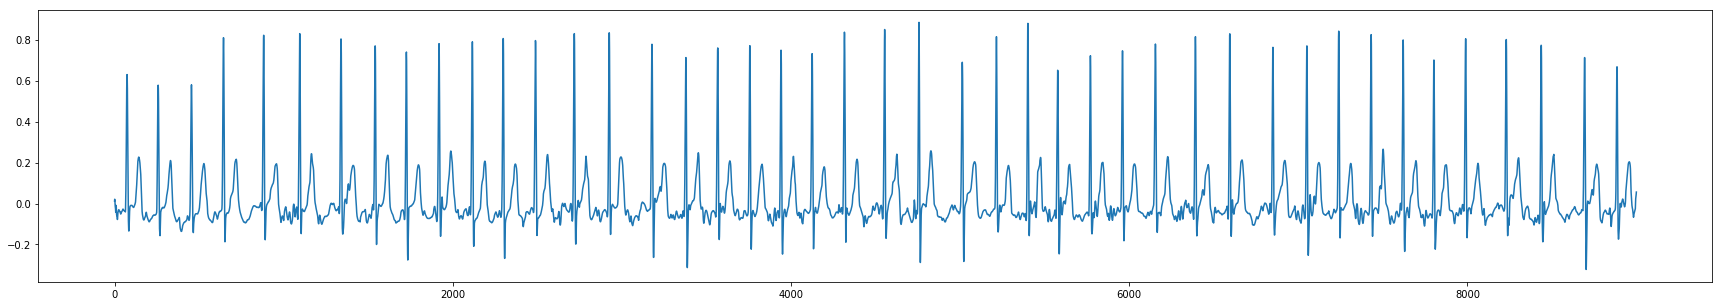

In [46]:
i = 2
show(f1_X_val[i], f1_val_cat[i], f1_validation_prediction[i])

GT:3
Pred: 2


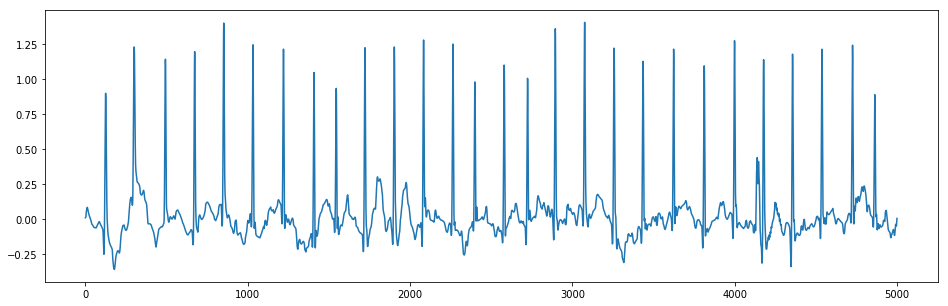

In [66]:
i = 164
show(f1_X_val[i][:5000], f1_val_cat[i], f1_validation_prediction[i])

In [16]:
for t in range(len(f1_val_cat)):
    if f1_val_cat[t] != f1_validation_prediction[t]:
        print(t)
        print("gt: {}".format(f1_val_cat[t]))
        print("pred: {}".format(f1_validation_prediction[t]))

4
gt: 0
pred: 3
7
gt: 0
pred: 3
8
gt: 0
pred: 3
17
gt: 0
pred: 3
19
gt: 0
pred: 3
24
gt: 0
pred: 3
32
gt: 0
pred: 3
33
gt: 0
pred: 3
40
gt: 0
pred: 3
43
gt: 0
pred: 3
59
gt: 0
pred: 3
62
gt: 0
pred: 3
77
gt: 0
pred: 2
80
gt: 0
pred: 2
82
gt: 1
pred: 3
85
gt: 1
pred: 2
98
gt: 1
pred: 2
102
gt: 1
pred: 3
103
gt: 1
pred: 2
109
gt: 3
pred: 2
113
gt: 3
pred: 0
117
gt: 3
pred: 2
129
gt: 3
pred: 2
131
gt: 3
pred: 2
137
gt: 3
pred: 0
150
gt: 3
pred: 2
154
gt: 3
pred: 2
163
gt: 3
pred: 2
164
gt: 3
pred: 2
165
gt: 3
pred: 0
167
gt: 3
pred: 2
182
gt: 3
pred: 2
187
gt: 3
pred: 2
193
gt: 3
pred: 2
198
gt: 3
pred: 2
202
gt: 3
pred: 2
204
gt: 3
pred: 0
205
gt: 3
pred: 2
214
gt: 3
pred: 2
222
gt: 3
pred: 2
223
gt: 3
pred: 2
227
gt: 3
pred: 2
231
gt: 3
pred: 2
237
gt: 3
pred: 2
256
gt: 3
pred: 2
257
gt: 3
pred: 0
265
gt: 3
pred: 2
271
gt: 3
pred: 2
274
gt: 3
pred: 2
281
gt: 3
pred: 0
286
gt: 3
pred: 2
289
gt: 3
pred: 2
292
gt: 3
pred: 2
304
gt: 3
pred: 2
305
gt: 3
pred: 1
319
gt: 3
pred: 2
322
gt: 3
pr

In [25]:
for t in range(len(f1_val_cat)):
    if f1_val_cat[t] == f1_validation_prediction[t]:
        print(t)
        print("gt: {}".format(f1_val_cat[t]))
        print("pred: {}".format(f1_validation_prediction[t]))

0
gt: 0
pred: 0
1
gt: 0
pred: 0
2
gt: 0
pred: 0
3
gt: 0
pred: 0
5
gt: 0
pred: 0
6
gt: 0
pred: 0
9
gt: 0
pred: 0
10
gt: 0
pred: 0
11
gt: 0
pred: 0
12
gt: 0
pred: 0
13
gt: 0
pred: 0
14
gt: 0
pred: 0
15
gt: 0
pred: 0
16
gt: 0
pred: 0
18
gt: 0
pred: 0
20
gt: 0
pred: 0
21
gt: 0
pred: 0
22
gt: 0
pred: 0
23
gt: 0
pred: 0
25
gt: 0
pred: 0
26
gt: 0
pred: 0
27
gt: 0
pred: 0
28
gt: 0
pred: 0
29
gt: 0
pred: 0
30
gt: 0
pred: 0
31
gt: 0
pred: 0
34
gt: 0
pred: 0
35
gt: 0
pred: 0
36
gt: 0
pred: 0
37
gt: 0
pred: 0
38
gt: 0
pred: 0
39
gt: 0
pred: 0
41
gt: 0
pred: 0
42
gt: 0
pred: 0
44
gt: 0
pred: 0
45
gt: 0
pred: 0
46
gt: 0
pred: 0
47
gt: 0
pred: 0
48
gt: 0
pred: 0
49
gt: 0
pred: 0
50
gt: 0
pred: 0
51
gt: 0
pred: 0
52
gt: 0
pred: 0
53
gt: 0
pred: 0
54
gt: 0
pred: 0
55
gt: 0
pred: 0
56
gt: 0
pred: 0
57
gt: 0
pred: 0
58
gt: 0
pred: 0
60
gt: 0
pred: 0
61
gt: 0
pred: 0
63
gt: 0
pred: 0
64
gt: 0
pred: 0
65
gt: 0
pred: 0
66
gt: 0
pred: 0
67
gt: 0
pred: 0
68
gt: 0
pred: 0
69
gt: 0
pred: 0
70
gt: 0
pred: 0
71
g

823
gt: 2
pred: 2
824
gt: 2
pred: 2
825
gt: 2
pred: 2
826
gt: 2
pred: 2
827
gt: 2
pred: 2
828
gt: 2
pred: 2
829
gt: 2
pred: 2
830
gt: 2
pred: 2
831
gt: 2
pred: 2
832
gt: 2
pred: 2
833
gt: 2
pred: 2
834
gt: 2
pred: 2
835
gt: 2
pred: 2
836
gt: 2
pred: 2
837
gt: 2
pred: 2
838
gt: 2
pred: 2
839
gt: 2
pred: 2
842
gt: 2
pred: 2
843
gt: 2
pred: 2
844
gt: 2
pred: 2
845
gt: 2
pred: 2
846
gt: 2
pred: 2
847
gt: 2
pred: 2
848
gt: 2
pred: 2
849
gt: 2
pred: 2
850
gt: 2
pred: 2
851
gt: 2
pred: 2
852
gt: 2
pred: 2
853
gt: 2
pred: 2
854
gt: 2
pred: 2
855
gt: 2
pred: 2
856
gt: 2
pred: 2
857
gt: 2
pred: 2
858
gt: 2
pred: 2
859
gt: 2
pred: 2
860
gt: 2
pred: 2
861
gt: 2
pred: 2
862
gt: 2
pred: 2
863
gt: 2
pred: 2
864
gt: 2
pred: 2
865
gt: 2
pred: 2
866
gt: 2
pred: 2
867
gt: 2
pred: 2
868
gt: 2
pred: 2
869
gt: 2
pred: 2
870
gt: 2
pred: 2
871
gt: 2
pred: 2
872
gt: 2
pred: 2
873
gt: 2
pred: 2
874
gt: 2
pred: 2
875
gt: 2
pred: 2
876
gt: 2
pred: 2
877
gt: 2
pred: 2
878
gt: 2
pred: 2
879
gt: 2
pred: 2
880
gt: 2


1792
gt: 2
pred: 2
1793
gt: 2
pred: 2
1794
gt: 2
pred: 2
1795
gt: 2
pred: 2
1796
gt: 2
pred: 2
1797
gt: 2
pred: 2
1799
gt: 2
pred: 2
1800
gt: 2
pred: 2
1801
gt: 2
pred: 2
1802
gt: 2
pred: 2
1803
gt: 2
pred: 2
1805
gt: 2
pred: 2
1806
gt: 2
pred: 2
1807
gt: 2
pred: 2
1808
gt: 2
pred: 2
1809
gt: 2
pred: 2
1810
gt: 2
pred: 2
1811
gt: 2
pred: 2
1812
gt: 2
pred: 2
1813
gt: 2
pred: 2
1814
gt: 2
pred: 2
1815
gt: 2
pred: 2
1817
gt: 2
pred: 2
1818
gt: 2
pred: 2
1820
gt: 2
pred: 2
1821
gt: 2
pred: 2
1822
gt: 2
pred: 2
1823
gt: 2
pred: 2
1824
gt: 2
pred: 2
1825
gt: 2
pred: 2
1826
gt: 2
pred: 2
1827
gt: 2
pred: 2
1828
gt: 2
pred: 2
1829
gt: 2
pred: 2
1830
gt: 2
pred: 2
1831
gt: 2
pred: 2
1834
gt: 2
pred: 2
1835
gt: 2
pred: 2
1836
gt: 2
pred: 2
1837
gt: 2
pred: 2
1838
gt: 2
pred: 2
1839
gt: 2
pred: 2
1840
gt: 2
pred: 2
1841
gt: 2
pred: 2
1843
gt: 2
pred: 2
1845
gt: 2
pred: 2
1846
gt: 2
pred: 2
1847
gt: 2
pred: 2
1848
gt: 2
pred: 2
1849
gt: 2
pred: 2
1850
gt: 2
pred: 2
1851
gt: 2
pred: 2
1852
gt: 2
p

In [61]:
import pylab as plt
def show(rec, gt, pred):
    plt.figure(figsize=(16,5))
    plt.plot(rec)
    print("GT:{}".format(gt))
    print("Pred: {}".format(pred))
    plt.show()